# Summary of this notebook

In this notebook, we create our baseline models that we will use as a basis of comparison for our production model.  We first explain why it is appropriate to evaluate our models in terms of *binary cross-entropy (BCE) score* and not merely accuracy score.  We then give a brief overview of the primary player-rating systems in use today, "Elo" and "Glicko".  We explain why it is not possible to perfectly replicate the winner-prediction model used on Lichess.org with the data available to us, and then we determine which models might be reasonable baselines.  Finally, we construct and evaluate these baseline models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn import metrics
from sklearn.model_selection import train_test_split

from helper_functions import elo_expectation, glicko_expectation

# Background

Here, we explain which metrics we will use to evaluate our models.  We then briefly summarize the Elo and Glicko ratings systems that are in wide use today, including on Lichess.org.  Finally, we explain which models we will use as baselines for comparison with our production model.

## Metrics for Evaluating Models: BCE, MAE and Accuracy

The problem with which we have tasked ourselves is to predict the outcome of a new player's 2nd-ever game on Lichess.org so that we can create better matchmaking for new players.  To adequately address this problem, we must ask: What makes for a good match between two players?

A "good match" should be one wherein the two players have similar "skill."  Framed differently, a good match is one where the *probability that Player 1 beats Player 2* is as close to 50% as possible.  In order to select between all the potential matches that could be made for a new player, we must therefore be able to predict the *probability* that the new player would win / lose if matched against a given opponent.

This means that discrete predictions (or "classifications") of the form "We expect new player A to lose if paired against opponent X in her 2nd game" or "We expect new player B to win if paired against opponent Y in her 2nd game" are *not sufficient* for our purposes.  We need our models to produce *probabilistic predictions*.

Similarly, given two models that probabilistically predict the outcomes of new players' 2nd games, we should not compare the two models merely in terms of their *accuracy scores*: we should also compare them in terms of a metric that penalizes models *more strongly* if their probabilistic predictions are *farther* from the truth.  For this reason, we compare models primarily on the basis of *[binary cross-entropy (BCE)](https://en.wikipedia.org/wiki/Cross_entropy)* score and only secondarily on the basis of accuracy score.

Indeed, BCE is a standard metric used to evaluate player-rating models.  It was used, for example, in the [Deloitte/FIDE Chess Rating Challenge](https://www.kaggle.com/c/ChessRatings2/overview/custom).  (Technically this competition scored models on the basis of [Binomial Deviance](https://stats.stackexchange.com/questions/371476/calculate-binomial-deviance-binomial-log-likelihood-in-the-test-dataset), which is just a constant times BCE.)

We will also use Mean Absolute Error (MAE or "$\mathcal{L}^1$ loss") as a secondary metric to evaluate our models' predictions.  Like BCE, MAE penalizes models for making probabilistic predictions that are *farther* from the truth: for example, if the true value is 1 and the model predicts .3, this prediction receives a larger loss than if it had predicted .4 (even though the discrete prediction is the same in both cases).

## BCE or MAE as the loss function for good matchmaking?

When compared to BCE, MAE has the advantage of being especially easy to interpret: MAE is simply the average amount by which the model's probabilistic predictions are "off" from the truth.  Unlike BCE, though, MAE does *not* have the advantage of penalizing *each additional unit of distance from the truth* by *greater and greater amounts*.

This "increasing marginal loss" property of BCE is a desirable property of a loss function when trying to make good matches between players.  For example, consider the following two possible models:
- Model A is off by about .2 units of probability for all observations.
- Model B is off by about .04 units of probability in 2/3 of observations and is off by about .5 units of probability in 1/3 of observations (where these "2/3 or 1/3" cases are split independently of the model's estimated probability that Player 1 will win).

Model A will likely lead to reasonably good chess matches between all players.  When Model A finds a match for which its estimated win probability of Player 1 is .55, the true win probability for player 1 will be approximately in the interval \[.35, .75\].  Even in the case where Player 1's win probability is .75, Player 2 stands a reasonable fighting chance.

Model B, on the other hand, is likely to make *exceptionally good* matches in 2/3 of cases but *potentially horrible* matches in 1/3 of cases.  Indeed, in the 1/3 of cases in which it is off by about .5, the true win probability for Player 1 could be *as small as 0* or *as large as 1*.  This means that in about 1/3 of cases where the model has identified a "good match", it may have actually identified a *horrible match*: potentially a bad experience that causes one or both players to spend less time on the chess platform in the future.  Thus, for the purposes of good matchmaking, model A is preferable to model B.

A BCE loss function therefore makes the "correct" choice between models A and B: Model A has a BCE loss of $-\ln(.8) = .223$ while Model B has a larger BCE loss of $(2/3) \ln(.96) + (1/3) \ln(.5) = .258$ (see below for a review of these calculations).  However, the MAE loss function makes the "wrong" choice here: Model A has a MAE of .2, while model B's MAE is only .193.

For these reasons, even though BCE is less easily interpretable than MAE, we will use BCE as our primary metric to evaluate models.

### A review of BCE loss

For a traditional binary classification problem, the BCE loss between a vector of predictions and a vector of (true) taregt values (each 0 or 1) is computed as follows.

1. For each observation, compute the natural logarithm of (1 minus the distance between the prediction and the true value).
- For example, if for one observation the prediction is .7 and the true value is 1, then the distance between the true value and the prediction is .3, so 1 minus this distance is .7, meaning the log is $ln(.7) = -0.357$.
- If for another observation the prediction is .7 and instead the true value is 0, then the distance between the true value and the prediction is .7, so 1 minus this distance is .3, meaning the log is $ln(.3) = -1.204$.
- If for a third observation the prediction is .9 and the true value is 1, then the log is $ln(.9) = -.105$.
- If for a 4th observation the prediction is 1.0 and the true value is 1, then the log is $ln(1) = 0$.  (In reality most sensible models will *never* make a probabilistic prediction of *exactly 1* or *exactly 0*, since if the prediction is wrong then the loss coming from this observation is $ln(0) = -\infty$.)

2. Average the computed logs across all observations in the vector, then take the negative of this average.
- In our example, this means that the BCE loss is
$$ \frac{1}{4}(.357 + 1.204 + .105 + 0) = 0.4165.$$

As we can see, when the true value is 1 (respectively, 0), a prediction closer to 1 (respectively, 0) means the loss due to this observation will be smaller.

### A note about BCE loss when the "true value" can be probabilistic

In chess, the outcome of a game is *usually* a win or loss for a given player; however, there are also cases where a *draw* can occur.  In our data, the target variable (what we're trying to predict) measures the outcome of a new player's 2nd game on Lichess.org.  It is encoded as follows:
- A "1" means that the new player won.
- A "0" means that the new player lost.
- A ".5" means that the new player *had a draw*.

If we use these numbers as the "true values" in a manner similar to the above - so that the "true value" is now not always 0 or 1, but can sometimes be .5 - then we still arrive at a sensible loss function.  Let's look at a few examples:
- If for one observation the prediction is .7 and the true value is .5, then the distance between the true value and the prediction is .2, so 1 minus this distance is .8, meaning the log is $ln(.8) = -.223$.

As we can see, the loss from this observation (where we predicted ".7") when the true value is .5 is *smaller* than the loss would be if the true value were 1 or 0.  This is because .7 is closer to .5 than it is to 1 or 0.

- If we predicted .5 and the true value is .5, then the distance is 0, so 1 minus the distance is 1, so the log is $ln(1) = 0$.

As we can see, in case of a draw, a prediction of .5 is rewarded with *no loss at all* for that observation.

- If we predicted 1 and the true value is .5, then the distance is .5, so 1 minus the distance is also .5, so the log is $ln(.5) = -.693$.

Thus - unlike when the true value is 0 or 1 and we can potentially achieve an *arbitrarily large loss* if our prediction is too far from the true value - when the true value is .5 the maximum loss that can be achieved from a single observation is $.693$, and it is achieved when the prediction is too confident on *either* 0 or 1.  This maximum-loss-from-a-single-observation value of .693 is the same as the loss that would be achieved by a prediction of .5 when the true value is *either* 0 or 1.

The BCE loss function therefore generalizes quite naturally to the case where a "draw" is encoded as a value of .5.


### How we'll compute BCE loss when training our models

We will use [PyTorch's built-in BCE loss function](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) to compute BCE loss in this project.  This function applies the same method mentioned above, except it "clamps its log function outputs to be greater than or equal to -100."  That is, to avoid the problem of a loss value from a single observation swamping all other loss values (which is particularly dangerous when training models using gradient descent), this function substitutes a value of -100 whenever the "log" caluclation for a single observation would yield a value even more negative than -100.

## Elo and Glicko Ratings Systems

The [International Chess Federation (FIDE)](https://www.fide.com/) uses the [Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system) to rate its players, while many chess websites (including Lichess.org) use variants of the more advnaced [Glicko rating system](https://www.glicko.net/glicko.html).  For a good introduction to the most basic variant, Glicko-1, see [this document](https://www.glicko.net/glicko/glicko.pdf).

Regardless of whether one uses the Elo system or the Glicko system, the center and spread of the long-run distribution of players' ratings will be a function of (1) the initial rating that you choose to give to all new players and (2) some paramters of the rules used to update ratings.  Lichess.org uses an initial rating of 1500 and sets its paramters such that nearly all players have a rating between around 600 and 2700 in its [long-run distribution](https://lichess.org/stat/rating/distribution/rapid).

Essentially, both the Elo and Glicko systems model players' skill through a "rating" score in such a way that if two players P1 and P2 have ratings $r_1$ and $r_2$ prior to playing each other, then the expected probability $E$ that P1 defeats P2 is a logistic function of the ratings difference $(r_1 - r_2)$.  The exact parameters of this logistic function depend upon the parameters chosen in (2) above, but for a Lichess-like distribution, the Elo function looks like

$$E_{Elo} = \frac{1}{1+10^{-(r_1-r_2)/400}}.$$

The Elo scoring system updates players' ratings based on who defeats whom (and the ratings of the players who won/lost); the exact method for updating scores is not important for our analysis.

Under the Glicko system, players' ratings are reported not as point estimates but instead as 95% confidence intervals.  Each player $i$ has both a *rating* $r_i$ and a *rating deviation* $RD_i$ so that the 95% confidence interval for the player's "true rating" is

$$ r_i \pm RD_i. $$

(We follow the definition of "ratings deviation" used by Lichess.org; another common definition defines $RD_i$ such that the 95% confidence interval is $r_i \pm 1.96 RD_i$.) After the players play against each other (perhaps multiple times, during a "rating period"), the Glicko system has a formula for updating the players' ratings *and* their ratings deviations based on (A) the outcome(s) of their match(es) and (B) the players' ratings and ratings deviations prior to their match(es).  Crucially, as a player plays more matches (within a given rating period, at least), her ratings deviation always goes *down*.  That is, as the player plays more games and we observe the games' outcomes, we become more and more certain about her skill level.

When computing the expected probability that P1 defeats P2, the Glicko system takes into account both the players' ratings and their ratings deviations.  For a Lichess-like distribution, the expectation function (i.e. expected probability that P1 defeats P2) is

$$E_{Glicko} = \frac{1}{1+10^{-g\left(\sqrt{RD_1^2 + RD_2^2}\right) \cdot (r_1-r_2)/400}}$$

where $g : \mathbb{R} \to (0,1]$ is the strictly decreasing positive function given by

$$ g(x) = \frac{1}{\sqrt{1 + \frac{3q^2}{\pi^2} x^2}}$$

where $q = \ln(10)/400$.  As we can see, the Glicko expectation function is the same as the Elo expectation function, except it *downweights* the exponent in the denominator towards 0: all else equal, if *either* player's ratings deviation $RD_1$ or $RD_2$ increases, then the weighting factor $g\left(\sqrt{RD_1^2 + RD_2^2}\right)$ gets closer to 0, causing the expected probability that P1 defeats P2 to get closer to $\frac{1}{2}$.

This means that the Glicko system makes an Elo-like prediction of who will win, but downweights its prediction based on how much uncertainty there is about the players' ratings.  In the extreme case where both players have a ratings deviation of 0 (no uncertainty), the Glicko system's expectation function reverts to the Elo expectation function; that is, there is no downweighting.  In the other extreme where one or both players have exceptionally large ratings deviations (lots of uncertainty), the Glicko system's expectation will be very close to $\frac{1}{2}$; that is, it downweights all the way to an uninformed guess.

Below, we plot the Glicko expectation of a game's outcome as a function of the difference $r_1 - r_2$ between the two players' ratings.  We plot this function for various values of the players' ratings deviations.

In [2]:
xs = np.linspace(0,1200,1000)
elos = [glicko_expectation(x, 0, 0, 0) for x in xs]
glickos_minRD = [glicko_expectation(x, 0, 45, 45) for x in xs]
glickos_maxcertainRD = [glicko_expectation(x, 0, 110, 110) for x in xs]
glickos_500RD = [glicko_expectation(x, 0, 500, 500) for x in xs]
glickos_startingRD = [glicko_expectation(x, 0, 1000, 1000) for x in xs]

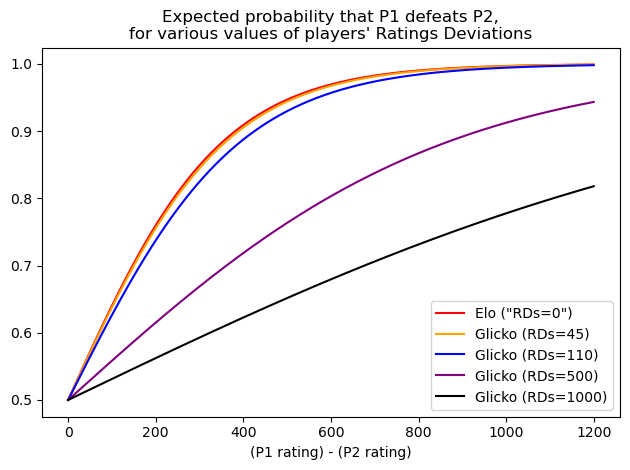

In [3]:
plt.plot(xs, elos, 'r', label='Elo ("RDs=0")')
plt.plot(xs, glickos_minRD, 'orange', label='Glicko (RDs=45)')
plt.plot(xs, glickos_maxcertainRD, 'blue', label='Glicko (RDs=110)')
plt.plot(xs, glickos_500RD, 'purple', label='Glicko (RDs=500)')
plt.plot(xs, glickos_startingRD, 'black', label='Glicko (RDs=1000)')
plt.xlabel('(P1 rating) - (P2 rating)')
plt.title("Expected probability that P1 defeats P2,\nfor various values of players' Ratings Deviations")
plt.legend();
plt.tight_layout();
plt.savefig('../images/glicko_expectations.jpg');

- The top curve is the Glicko expectation function when both players have a ratings deviation (RD) of 0; that is, it is equivalent to the Elo expectation function.
- The next curve down is the Glicko expectation function when both players have RD = 45.  This is the minimum RD that players can have on Lichess.org; it is achieved after a player has played many games.  As we can see, its predictions are very close to those of the Elo curve.
- The third curve is when both players have RD = 110.  This is the minimum RD needed on Lichess.org in order for your rating to not be considered "provisional".  Newer players with an RD greater than 110 bear a "?" next to their rating scores.
- The second-to-bottom curve is when both players have RD = 500.
- The bottom curve is when both players have RD = 1000, which is initial RD of a new player on LIchess.org (hence, the maximum possible RD).

As we can see, as long as P1 has a higher rating than P2, the Glicko model's *discrete* prediction is always that P1 defeats P2 (regardless of the players' RDs).  However, the *probabilistic* prediction is sensitive to both (I) the difference in the players' ratings and (II) the players' RDs.  The larger the players' RDs, the less confident is the probabilistic prediction that P1 defeats P2.  For example, consider a scenario where P1 has a rating of 1700 while P2 has a rating of 1500.  What is the expected probability that P1 defeats P2, for various values of the players' RDs?

In [4]:
#RDs = 0
glicko_expectation(p1_rating = 1700, p2_rating = 1500, p1_RD = 0, p2_RD = 0)

0.7597469266479578

In [5]:
#RDs = 45
glicko_expectation(p1_rating = 1700, p2_rating =1500, p1_RD = 45, p2_RD = 45)

0.755562886725642

In [6]:
#RDs = 1000
glicko_expectation(p1_rating = 1700, p2_rating =1500, p1_RD = 1000, p2_RD = 1000)

0.562267801322134

### Why we can't precisely replicate Lichess.org's winner-prediction algorithm

More advanced versions of the Glicko system take other factors into account so that they can make better predictions (i.e., lower BCE with the true distribution of match outcomes).  For example, the [Glicko-2 system](https://www.glicko.net/glicko/glicko2.pdf) also keeps track of a "ratings volatility" measure for each player.  Lichess.org uses a variant of the even more advanced "Glicko-Boost" system; however, most of the values used in this system are invisible to the players.  At any given time, one can only view one's rating score and rating deviation.

Lichess.org also does not report players' ratings deviations in their [publicly available databases](https://database.lichess.org/); instead, for each match it merely reports the players' (point) ratings and the amount of points each player gained or lost after the match.  Even if Lichess.org *did* report the ratings deviations, though, it would be quite difficult to precisely replicate the probabilistic predictions made by their Glicko model (and not just because we'd also be missing the ratings volatility scores!).  This is because the procedure necessary to account for real-time updating of ratings (instead of updating everyone's ratings simultaneously, once per "rating period") is complicated.  See [this repository](https://gist.github.com/gpluscb/302d6b71a8d0fe9f4350d45bc828f802) for details.

In summary, Lichess.org does not supply sufficient data to replicate their winner-prediction algorithm or even a simpler Glicko-1 algorithm.

# Baseline models we will use

Thus, we can't compare our more advanced models' predictions to those *actually used* by Lichess.org.  Instead, we will have to settle for 4 baseline models:

0. The "null model" that always predicts (with 100% probability) the plurality outcome.
1. An "uninformed" model that always predicts that each player will win with 50% probability.
2. The Elo model (equivalently, a Glicko model with both players' ratings deviations set to 0).
3. A Glicko model where we always set both players' ratings deviations to a constant $R$.  We will search the space of hyperparameters $R$ to find the best-performing value of $R$ in terms of BCE score on on the training data (and also check its BCE on the test data).

## Comparison to Lichess.org's model

In reality, rather than set $R$ to be constant across all players and games, the Glicko system determines a value of $R$ for each player before each game.  However, for the reasons outlined in the previous section, we cannot replicate such a system using only the data available from Lichess.org.  This baseline of setting $R$ to a constant for all players is the next-best thing we can do.

Nonetheless, since (in the game we're predicting) at least one of the two players is always *playing her 2nd-ever game Lichess.org*, we know that the ratings deviation of at least *one* of the players will be relatively constant across games.  This suggests that, although our baseline model number 3 will likely not make as good of predictions for new players' 2nd games (in terms of BCE loss) as the actual model used on Lichess.org does, it will likely make predictions that are *not too much worse* than the actual model used on Lichess.org.

Note also that although the different ratings deviations lead to different *probabilistic* predictions, the Glicko model's *discrete* prediction is always that *the player with a higher (point-estimate) rating will win*.  In this sense, all Glicko models (with any RD values for the players) make the same *discrete* prediction as an Elo model with the same values for the two players' ratings.

Hence, although baseline model 3 should have a BCE score that is better than that of model 2 (and presumably not quite as good as that of the actual model used on Lichess.org), when evaluating models by their *accuracy scores* models 2 and 3 will have the same score - and this will be the same as the score of the model used on Lichess.org.

## In Baseline Model 3, why not grid search for the new players' and opponents' ratings deviations separately?

As we said above, we are trying to predict the outcome of a new player's 2nd-ever game.  Given that new players always start with a ratings deviation of 1000 and only get to play *1 game* before the game for which we're making predictions, this means that nearly all new players will have a roughly-constant ratings deviation (say, around 900) at the beginning of the game for which we are making predictions.  So why not try a model that assumes the following?

- New players always have a ratings deviation of a certain constant value $R_{new}$.
- Their opponents always have a ratings deviation of a (possibly different) constant value $R_{opp}$.

Then instead of searching a 1-dimensional space for the best value of $R$ that *all* players have, we can search a 2-dimensional space for the best *pair* of values $R_{new}, R_{opp}$!  This should give us more freedom, right?

In fact, this approach should do *exactly as well* as the 1-dimensional search.  Indeed, the Glicko expectation function only cares about the two players' ratings deviations $R_{old}$ and $R_{new}$ in terms of the sum of their squares - recall that

$$E_{Glicko} = \frac{1}{1+10^{-g\left(\sqrt{RD_1^2 + RD_2^2}\right) \cdot (r_1-r_2)/400}}.$$

This means that, for any pair of values $R_{old}$ and $R_{new}$ that one might claim "do better than any single value $R$," we can construct a single value $R$ that does just as well as the combination of $R_{new}$ and $R_{old}$.  Simply choose

$$ R = \sqrt{.5(R_{new}^2 + R_{opp}^2)} $$

and it will be the case that

$$ R^2 + R^2 = R_{new}^2 + R_{opp}^2 $$

and hence that the Glicko expectation function $E_{Glicko}$ will take on the *exact same value* (for any two players) when we assume that *both players' ratings deviations equal* $R$ instead of assuming that *the new player's is $R_{new}$ and the opponent's is $R_{opp}$*.


## Data Import

In [7]:
train_2nd = pd.read_csv('../data/processed/train/train_2nd.csv', index_col='name_of_pl_playing_2nd_game')
test_2nd = pd.read_csv('../data/processed/test/test_2nd.csv', index_col='name_of_pl_playing_2nd_game')
val_2nd = pd.read_csv('../data/processed/val/val_2nd.csv', index_col='name_of_pl_playing_2nd_game')

In [8]:
train_2nd.head(1)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_2nd_game
name_of_pl_playing_2nd_game,,,,,,,,,,,,,,,,,
SAKATBIRAKAN,kami1946,White,1.0,1500.0,1608.0,237.0,-9.0,139,360.0,0.0,Blitz,Normal,1,2016-07-13 20:29:44,1.468442e+09,e4 b6 d4 Bb7 Nc3 e6 Nf3 Bb4 Bd3 Ne7 Bd2 Ng6 a3...,0


## Distribution of target variable (training data)

In [9]:
dist = train_2nd['new_pl_won'].value_counts(normalize=True)
dist

0.0    0.517728
1.0    0.445788
0.5    0.036484
Name: new_pl_won, dtype: float64

In [10]:
dist[1.0]/(dist[1.0]+dist[0.0])

0.4626683608640407

We see that in the new players' 2nd-ever games, only 3.6% were draws.  Among those games that were not draws, the new player won 46.3% of the time.

Thus, the null model always predicts that *the new player loses* (predicted probability of win = 0.0).  Among non-drawn games in the training data, it achieves an accuracy score of 53.7%.

## Accuracy Scores

In [11]:
#For accuracy scores, we're interested only in those games that aren't a draw
train_2nd_nodraws = train_2nd[(train_2nd['new_pl_won'] > .55) | (train_2nd['new_pl_won'] < .45)]
test_2nd_nodraws = test_2nd[(test_2nd['new_pl_won'] > .55) | (test_2nd['new_pl_won'] < .45)]
val_2nd_nodraws = val_2nd[(val_2nd['new_pl_won'] > .55) | (val_2nd['new_pl_won'] < .45)]

In [12]:
dfs_dict = {
   'train':train_2nd,
    'test':test_2nd,
     'val':val_2nd
}

dfs_dict_nodraws = {
   'train':train_2nd_nodraws,
    'test':test_2nd_nodraws,
     'val':val_2nd_nodraws
}

In [25]:
#Get the true values as integers instead of floats
target_nodraws_train = np.array([int(x) for x in train_2nd_nodraws['new_pl_won']])
target_nodraws_test = np.array([int(x) for x in test_2nd_nodraws['new_pl_won']])
target_nodraws_val = np.array([int(x) for x in val_2nd_nodraws['new_pl_won']])

target_nodraws = {
    'train':target_nodraws_train,
    'test':target_nodraws_test,
    'val':target_nodraws_val
}

In [26]:
# Accuracy of ALL Elo/Glicko models on non-drawn games
#(Recall that all Elo/Glicko models make the same DISCRETE predictions)
acc = {}

#Training accuracy
preds_train = train_2nd_nodraws.apply(lambda row : elo_expectation(row['new_pl_elo'], row['opp_elo']), axis=1)
preds_array_train = np.array([round(x, 0) for x in preds_train])
acc['train'] = metrics.accuracy_score(target_nodraws_train, preds_array_train)

#Test accuracy
preds_test = test_2nd_nodraws.apply(lambda row : elo_expectation(row['new_pl_elo'], row['opp_elo']), axis=1)
preds_array_test = np.array([round(x, 0) for x in preds_test])
acc['test'] = metrics.accuracy_score(target_nodraws_test, preds_array_test)

#Val accuracy
preds_val = val_2nd_nodraws.apply(lambda row : elo_expectation(row['new_pl_elo'], row['opp_elo']), axis=1)
preds_array_val = np.array([round(x, 0) for x in preds_val])
acc['val'] = metrics.accuracy_score(target_nodraws_val, preds_array_val)

#Report the train, test and val accuracy scores
acc

{'train': 0.6214993646759848,
 'test': 0.6357340720221607,
 'val': 0.6281163434903048}

In [29]:
# Accuracy of null model
null_acc = {}
null_preds_nodraws = {}

for kind in ['train', 'test', 'val']:
    null_preds_nodraws[kind] = np.array([ 0 for _ in range(len(dfs_dict_nodraws[kind])) ])
    null_acc[kind] = metrics.accuracy_score(target_nodraws[kind], null_preds_nodraws[kind])

null_acc

{'train': 0.5373316391359594,
 'test': 0.5373961218836565,
 'val': 0.5450138504155124}

## Function to compute BCE Loss

In [14]:
def bce_loss(y_true, y_pred):
    '''
    Inputs:
    -y_true: A Pandas series, Numpy array, or list of true values (0, 1, or .5)
    -y_pred: A Pandas series, Numpy array, or list of predicted values
    Uses PyTorch to compute BCE loss between the two inputted series.
    '''
    y_true = torch.from_numpy(np.array(list(y_true)))
    y_pred = torch.from_numpy(np.array(list(y_pred)))
    
    return nn.BCELoss()(y_pred, y_true).item()

## Get the true target values

In [15]:
target_train = train_2nd['new_pl_won']
target_test = test_2nd['new_pl_won']
target_val = val_2nd['new_pl_won']

target = {
   'train':target_train,
    'test':target_test,
     'val':target_val
}

## Null model

In [35]:
results_dict = {}
results_dict['Null Model'] = {}
null_preds = {}

for kind in ['train', 'test', 'val']:
    #Get the null model's predictions
    null_preds[kind] = np.array([ 0 for _ in range(len(dfs_dict[kind])) ])
    
    #Infinite BCE loss since null model predicts 0.0 and some observations are 1.0
    results_dict['Null Model'][f"bce_{kind}"] = 'Infinite'
    results_dict['Null Model'][f"mae_{kind}"] = metrics.mean_absolute_error(target[kind], null_preds[kind])
    results_dict['Null Model'][f"acc_{kind}"] = null_acc[kind]
    
results_df = pd.DataFrame(results_dict).T
results_df[['bce_train', 'bce_test', 'bce_val', 'mae_train', 'mae_test', 'mae_val', 'acc_train', 'acc_test', 'acc_val']]

,bce_train,bce_test,bce_val,mae_train,mae_test,mae_val,acc_train,acc_test,acc_val
Null Model,Infinite,Infinite,Infinite,0.46403,0.464,0.456667,0.537332,0.537396,0.545014


## "Uninformed" baseline model

In [36]:
#Get the BCE loss values for train, test and val
uninformed_bce = {}

for kind in ['train', 'test', 'val']:
    uninformed_bce[kind] = bce_loss(
        target[kind], [.5 for _ in range(len(dfs_dict[kind]))]
    )

In [37]:
(uninformed_bce['train'], uninformed_bce['test'], uninformed_bce['val'])

(0.6931471805599453, 0.6931471805599454, 0.6931471805599454)

As we can see, the BCE loss for the "uninformed" model (that always predicts .5) is the same in the train, test, and val data.  This fits with the earlier discussion of BCE above: each observation contributes a loss of $ln(.5) = .693147$, so the average is also $.693147$.

In [38]:
results_dict['Uninformed Model'] = {}

for kind in ['train', 'test', 'val']:
    #Get the uninformed model's predictions
    uninformed_preds = np.array([ .5 for _ in range(len(dfs_dict[kind])) ])
    
    #Accuracy is .5 since it predicts randomly
    results_dict['Uninformed Model'][f"acc_{kind}"] = .5
    results_dict['Uninformed Model'][f"bce_{kind}"] = uninformed_bce[kind]
    results_dict['Uninformed Model'][f"mae_{kind}"] = metrics.mean_absolute_error(target[kind], uninformed_preds)
    
results_df = pd.DataFrame(results_dict).T
results_df[['bce_train', 'bce_test', 'bce_val', 'mae_train', 'mae_test', 'mae_val', 'acc_train', 'acc_test', 'acc_val']]

,bce_train,bce_test,bce_val,mae_train,mae_test,mae_val,acc_train,acc_test,acc_val
Null Model,Infinite,Infinite,Infinite,0.46403,0.464,0.456667,0.537332,0.537396,0.545014
Uninformed Model,0.693147,0.693147,0.693147,0.481758,0.481333,0.481333,0.5,0.5,0.5


## Elo baseline model

In [39]:
preds = {}
elo_bce = {}
results_dict['Elo Model'] = {}

for kind in ['train', 'test', 'val']:
    #Get the predicted probabilities
    preds[kind] = dfs_dict[kind].apply(
        lambda row : elo_expectation(row['new_pl_elo'], row['opp_elo']), axis=1
    )
    
    #Find the BCE loss
    elo_bce[kind] = bce_loss(target[kind], preds[kind])
    
    results_dict['Elo Model'][f"bce_{kind}"] = elo_bce[kind]
    results_dict['Elo Model'][f"mae_{kind}"] = metrics.mean_absolute_error(target[kind], preds[kind])
    results_dict['Elo Model'][f"acc_{kind}"] = acc[kind]
    
results_df = pd.DataFrame(results_dict).T
results_df[['bce_train', 'bce_test', 'bce_val', 'mae_train', 'mae_test', 'mae_val', 'acc_train', 'acc_test', 'acc_val']]

,bce_train,bce_test,bce_val,mae_train,mae_test,mae_val,acc_train,acc_test,acc_val
Null Model,Infinite,Infinite,Infinite,0.46403,0.464,0.456667,0.537332,0.537396,0.545014
Uninformed Model,0.693147,0.693147,0.693147,0.481758,0.481333,0.481333,0.5,0.5,0.5
Elo Model,0.687638,0.673591,0.686807,0.419215,0.411154,0.421461,0.621499,0.635734,0.628116


## Optimal "Glicko" baseline model

As mentioned above, we lack the data to compute *each player's* ratings deviation.  Hence, the best "Glicko" model we can make is one wherein we assume that all players will have *the same* ratings deviation $R$, then we perform a grid search for the best hyperparameter $R$.

In [20]:
def best_glicko_rd(rds):
    '''
    Input: A list of values R to try as the "ratings deviation" for all players
    
    For each given value of R, computes the BCE loss (on the training data) of the Glicko
    predictions that would be made if all players had that R as their ratings deviation.
    '''
    best_loss = np.inf
    best_R = 0
    
    for R in rds:
        #Get the Glicko predicted probabilities for this value of R (on the training data)
        glicko_preds = train_2nd.apply(
            lambda row : glicko_expectation(row['new_pl_elo'], row['opp_elo'], R, R), axis=1
        )
    
        #Compute the BCE loss (training data)
        loss = bce_loss(target_train, glicko_preds)
    
        #If this is the best loss so far, record it and the value of R
        if loss < best_loss:
            best_loss = loss
            best_R = R
            
    return best_loss, best_R

In [21]:
#Search over values of R between 0 and 1000, in increments of 10
rds = np.linspace(0, 1000, 101)

#What are the best loss and the best R?
best_glicko_rd(rds)

(0.6509502984234534, 410.0)

Let's try anoter more refined gridsearch:

In [22]:
rds_fine = np.linspace(400, 420, 21)

best_bce, best_R = best_glicko_rd(rds_fine)
best_bce, best_R

(0.6509496536218344, 408.0)

### Evaluate the predictions of this model

In [40]:
preds = {}
glicko_bce = {}
results_dict['"Glicko" Model'] = {}

for kind in ['train', 'test', 'val']:
    #Get the predicted probabilities
    preds[kind] = dfs_dict[kind].apply(
        lambda row : glicko_expectation(row['new_pl_elo'], row['opp_elo'], best_R, best_R), axis=1
    )
    
    #Find the BCE loss
    glicko_bce[kind] = bce_loss(target[kind], preds[kind])
    
    #Add the BCE loss & accuracy to our dictionary (accuracy is same as Elo model)
    results_dict['"Glicko" Model'][f"bce_{kind}"] = glicko_bce[kind]
    results_dict['"Glicko" Model'][f"mae_{kind}"] = metrics.mean_absolute_error(target[kind], preds[kind])
    results_dict['"Glicko" Model'][f"acc_{kind}"] = acc[kind]
    
results_df = pd.DataFrame(results_dict).T
results_df[['bce_train', 'bce_test', 'bce_val', 'mae_train', 'mae_test', 'mae_val', 'acc_train', 'acc_test', 'acc_val']]

,bce_train,bce_test,bce_val,mae_train,mae_test,mae_val,acc_train,acc_test,acc_val
Null Model,Infinite,Infinite,Infinite,0.46403,0.464,0.456667,0.537332,0.537396,0.545014
Uninformed Model,0.693147,0.693147,0.693147,0.481758,0.481333,0.481333,0.5,0.5,0.5
Elo Model,0.687638,0.673591,0.686807,0.419215,0.411154,0.421461,0.621499,0.635734,0.628116
"""Glicko"" Model",0.65095,0.643291,0.652622,0.445177,0.440259,0.446432,0.621499,0.635734,0.628116


In [48]:
results_df = results_df[['bce_train', 'bce_test', 'bce_val', 'mae_train', 'mae_test', 'mae_val', 'acc_train', 'acc_test', 'acc_val']]
results_df.index.name = 'model_name'

results_df.to_csv('../data/baseline_results.csv', index_label='model_name')

## Interpreting the BCE vs. MAE scores

As we can see, the MAE loss function selects the Elo model over the "Glicko" model.  The Elo model is *more certain* of its discrete predictions, meaning its probabilistic predictions are closer to the truth *in terms of average distance* than those of the Glicko model.  However, because the Glicko model's probabilistic predictions are weighted more towards a "neutral" prediction of .5, it , there are fewer situations where the Glicko model is off by a *very large amount* than there are for the Elo model.

As mentioned above, the most important situations to avoid when trying to make good matches are situations where the model's predictions are off by a *large amount*.  Perhaps this partially explains why Lichess.org uses Glicko ratings rather than Elo ratings!

# Looking at the predictions of the Elo and "Glicko" models

In [49]:
# Add the Elo and Glicko probabilistic predictions to the training data set
train_2nd['elo_pred'] = train_2nd.apply(
    lambda row : elo_expectation(row['new_pl_elo'], row['opp_elo']), axis=1
)

train_2nd['glicko_pred'] = train_2nd.apply(
    lambda row : glicko_expectation(row['new_pl_elo'], row['opp_elo'], best_R, best_R), axis=1
)

In [52]:
train_2nd[['new_pl_won', 'new_pl_elo', 'opp_elo', 'elo_pred', 'glicko_pred']].head()

,new_pl_won,new_pl_elo,opp_elo,elo_pred,glicko_pred
name_of_pl_playing_2nd_game,,,,,
SAKATBIRAKAN,1.0,1500.0,1608.0,0.349395,0.426055
bv44,0.0,1650.0,1580.0,0.599397,0.548132
mister_fix_it,1.0,1686.0,1608.0,0.610402,0.553593
samperallen,0.0,1186.0,1571.0,0.098302,0.256891
danielits,1.0,1235.0,1279.0,0.437015,0.469689


As we can see, both the Elo and Glicko models always predict that the higher-rater player will win.  However, the Glicko model's predictions are "downweighted" towards .5 as compared to the Elo model's predictions.

## Distributions of Predicted Probabilities, by game outcome

In [57]:
#Break the dataframe up by whether the new player won, lost, or had a draw
wins = train_2nd[train_2nd['new_pl_won']==1]
losses = train_2nd[train_2nd['new_pl_won']==0]
draws = train_2nd[train_2nd['new_pl_won']==.5]

In [59]:
#Check that we got all of the observations
len(wins) + len(losses) + len(draws) == len(train_2nd)

True

In [111]:
def glicko_vs_elo(df, description, bins=100):
    #Plot the histogram we want
    elo_preds = df['elo_pred']
    glicko_preds = df['glicko_pred']

    plt.hist(elo_preds, bins=bins, alpha=.5, label='Elo P[new pl wins]');
    plt.axvline(elo_preds.mean(), label = f"Elo mean: {round(elo_preds.mean(), 3)}");
    plt.hist(glicko_preds, bins=bins, alpha=.5, label='Glicko P[new pl wins]');
    plt.axvline(glicko_preds.mean(), color='red', label = f"Glikco mean: {round(glicko_preds.mean(), 3)}");
    
    plt.xticks(np.linspace(0,1,11));
    plt.xlim(0, 1);
    plt.ylabel("Frequency");
    plt.legend();
    plt.title(f"Elo vs. Glicko 2nd-game predictions (training data),\namong cases where the new player {description}");
    plt.tight_layout();
    plt.savefig(f'../images/elo_glicko_hist_{description}.jpg');

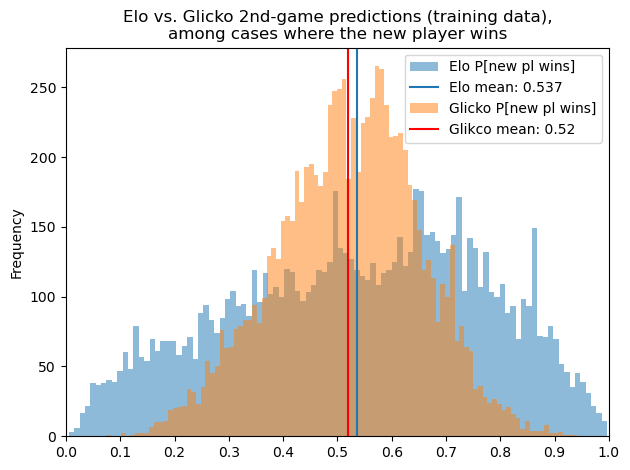

In [112]:
glicko_vs_elo(wins, 'wins')

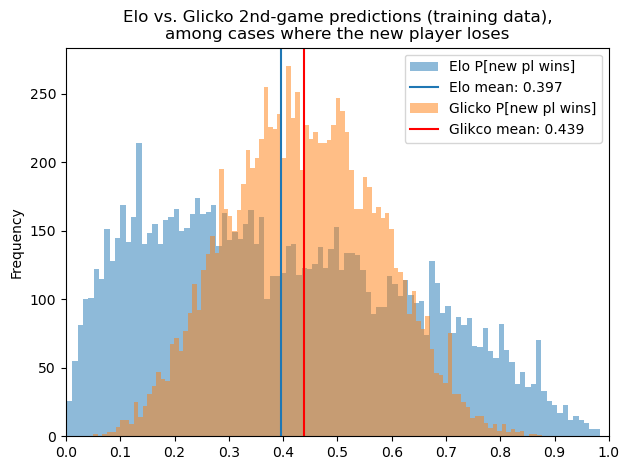

In [113]:
glicko_vs_elo(losses, 'loses')

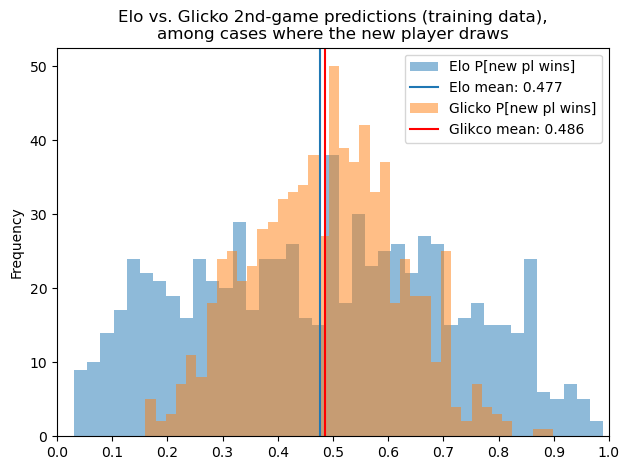

In [114]:
glicko_vs_elo(draws, 'draws', bins=40)